Ordinal Regression
--

Clement Tiennot, Camille Tiennot 2016
edits by James Hensman 2017

Ordinal regression aims at fitting a model to some data $(X, Y)$, where $Y$ is an ordinal variable. To do so, we use a `VPG` model with a specific likelihood (`gpflow.likelihoods.Ordinal`).

In [1]:
import gpflow
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

Text(0, 0.5, 'observed data value')

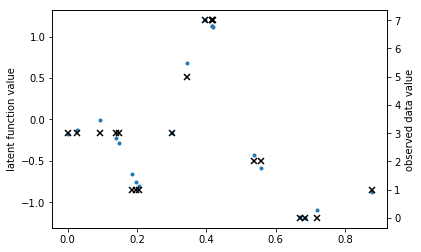

In [2]:
#make a one dimensional ordinal regression problem
np.random.seed(1)
num_data = 20
X = np.random.rand(num_data, 1)

# First, generate values of a latent GP
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(num_data)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(num_data, 1))

plt.plot(X, f, '.')
plt.ylabel('latent function value')

# Convert real values into ordinal ones
Y = np.round((f + f.min())*3)
Y = Y - Y.min()
Y = np.asarray(Y, np.float64)

plt.twinx()
plt.plot(X, Y, 'kx', mew=1.5)
plt.ylabel('observed data value')

In [9]:
# construct ordinal likelihood - bin_edges is the same as unique(Y) but centered
bin_edges = np.array(np.arange(np.unique(Y).size + 1), dtype=float)
bin_edges = bin_edges - bin_edges.mean()
likelihood=gpflow.likelihoods.Ordinal(bin_edges)

# build a model with this likelihood
m = gpflow.models.VGP(X, Y, 
                   kern=gpflow.kernels.Matern32(1),
                   likelihood=likelihood)

# fit the model
gpflow.train.ScipyOptimizer().minimize(m)

[-3. -2. -1.  0.  1.  2.  3.]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 23.361270
  Number of iterations: 163
  Number of functions evaluations: 188


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 23.361270
  Number of iterations: 163
  Number of functions evaluations: 188


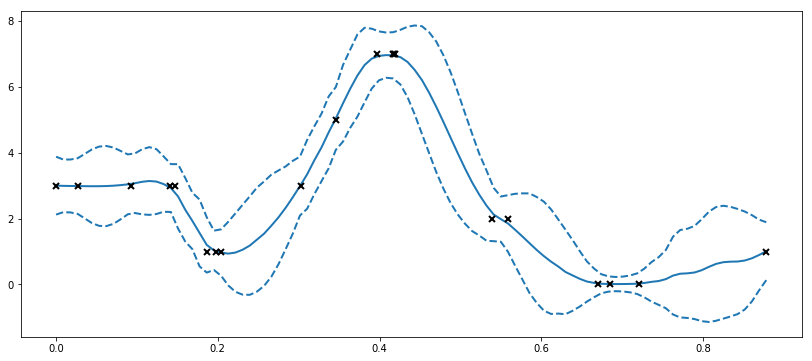

In [6]:
# here we'll plot the expected value of Y +- 2 std deviations, as if the distribution were Gaussian
plt.figure(figsize=(14, 6))
Xtest = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 100).reshape(-1, 1)
mu, var = m.predict_y(Xtest)
line, = plt.plot(Xtest, mu, lw=2)
col=line.get_color()
plt.plot(Xtest, mu+2*np.sqrt(var), '--', lw=2, color=col)
plt.plot(Xtest, mu-2*np.sqrt(var), '--', lw=2, color=col)
plt.plot(m.X.read_value(), m.Y.read_value(), 'kx', mew=2)

In [7]:
# to see the predictive density, try predicting every possible value.
def pred_density(m):
    Xtest = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 100).reshape(-1, 1)
    ys = np.arange(m.Y.read_value().max()+1)
    densities = []
    for y in ys:
        Ytest = np.ones_like(Xtest) * y
        densities.append(m.predict_density(Xtest, Ytest))
    return np.hstack(densities).T

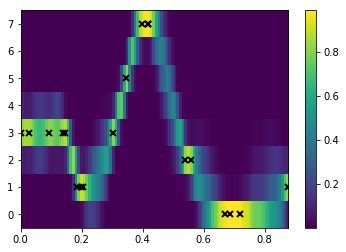

In [8]:
plt.imshow(np.exp(pred_density(m)), interpolation='nearest',
           extent=[m.X.read_value().min(), m.X.read_value().max(), -0.5, m.Y.read_value().max()+0.5],
           origin='lower', aspect='auto', cmap=plt.cm.viridis)
plt.colorbar()
plt.plot(X, Y, 'kx', mew=2, scalex=False, scaley=False)